In [498]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import spearmanr as scor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve as ROC
from sklearn.metrics import precision_recall_curve as PRC
from sklearn.metrics import auc as AUC

from cmapPy.pandasGEXpress.parse import parse

sns.set_style('whitegrid')
%matplotlib inline

## Confunding role of cell death signature in mechanism of action discovery
Perturbation gene expression signatures can be used to identify meachinsom of action (MoA) of unknown compounds (based on singature similarity). As cell death / proliferation has an important effect on gene expression sigantures, we hypothesised that cell death / proliferation can infer with MoA identification.

To test this hypothesis, we analysed the similarity between signature pairs (using Spearman correlation). We analysed the similarities between unrelated, toxic and shared MoA pairs.

In [604]:
def remove_space(s):
    """just some helper function to clean CTRP metadata
    removes space from end/start of string s"""
    while (s[0]==' ') or (s[-1]==' '):
        if s[0]==' ':
            s=s[1:]
        if s[-1]==' ':
            s=s[:-1]
    return s

In [605]:
#CTRP metadata desribes target of CTRP drugs
moa=pd.read_table('../data/CTRP/v20.meta.per_compound.txt',
                 sep='\t',header=0,index_col=[2])
#get targets and activities for these drugs
activities=[]
targets=[]
for cpd in moa.index:
    trg=str(moa.loc[cpd,'gene_symbol_of_protein_target']).split(';')
    targets+=trg
    act=str(moa.loc[cpd,'target_or_activity_of_compound']).split(';')
    act_new=[]
    for a in act:
        act_new.append(remove_space(a))
    act=act_new
    activities+=act
activities=list(set(activities))
targets=list(set(targets))
#create a matrix to store these targets and activities for compounds
activity_matrix=pd.DataFrame(0,index=moa.index,columns=activities)
target_matrix=pd.DataFrame(0,index=moa.index,columns=targets)
for cpd in moa.index:
    trg=str(moa.loc[cpd,'gene_symbol_of_protein_target']).split(';')
    act=str(moa.loc[cpd,'target_or_activity_of_compound']).split(';')
    act_new=[]
    for a in act:
        act_new.append(remove_space(a))
    act=act_new
    activity_matrix.loc[cpd,act]=1
    target_matrix.loc[cpd,trg]=1
# remove meaningless activities and targets
del target_matrix['nan']
del activity_matrix['product of diversity oriented synthesis']
del activity_matrix['screening hit']
del activity_matrix['natural product']
del activity_matrix['peptide mimetic']

In [606]:
#shared_moa matrix creation
#rows/columns are pert_ids, value is 1 if moa is shared, 0 if not
shared_moa=pd.DataFrame(np.identity(len(moa),int),index=moa.index,columns=moa.index)
for cpd in moa.index:
    acts=activity_matrix.columns[activity_matrix.loc[cpd]==1]
    sim_act=activity_matrix.index[np.sum(activity_matrix[acts],1)>0]
    shared_moa.loc[cpd,sim_act]=1
    trgs=target_matrix.columns[target_matrix.loc[cpd]==1]
    sim_trg=target_matrix.index[np.sum(target_matrix[trgs],1)>0]
    shared_moa.loc[cpd,sim_trg]=1
shared_moa.to_csv('../results/moa/shared_moa_ctrp.csv',sep=',')

Now we know which CTRP drugs have shared MoA. Next we calulate the similarities between CTRP-L1000 signatures.

(array([  5.82600000e+03,   2.69500000e+03,   6.41000000e+02,
          3.03000000e+02,   1.82000000e+02,   6.60000000e+01,
          2.90000000e+01,   1.20000000e+01,   1.00000000e+01,
          1.00000000e+00]),
 array([  259.2881078 ,   713.21726742,  1167.14642703,  1621.07558665,
         2075.00474627,  2528.93390589,  2982.86306551,  3436.79222512,
         3890.72138474,  4344.65054436,  4798.57970398]),
 <a list of 10 Patch objects>)

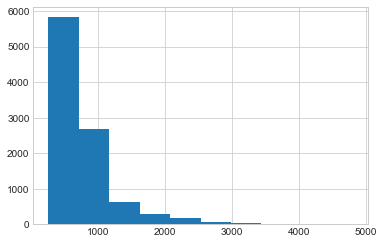

In [609]:
plt.hist(np.sum(np.abs(signatures),1))

In [569]:
sig_info=pd.read_table('../results/CTRP/sig_info_merged_lm.csv',
                      sep=',',header=0,index_col=[0])
signatures=pd.read_table('../results/CTRP/signatures_merged_lm.csv',
                        sep=',',header=0,index_col=[0])
fil=sig_info['pert_itime']=='24 h'
sig_info=sig_info[fil]
signatures=signatures.loc[sig_info.index]
similarity=pd.DataFrame(scor(signatures.T)[0],index=signatures.index,
                        columns=signatures.index)

Now we can create different masks to get: shared moa signatures / shared cell line signatures / toxic signatures / non toxic signautes.

In [570]:
#moa mask
moa_mask=pd.DataFrame(False,index=similarity.index,
                     columns=similarity.columns)
for cpd in shared_moa.index:
    sig_ids=sig_info.index[sig_info['pert_id']==cpd]
    similar_cpds=shared_moa.columns[shared_moa.loc[cpd]==1]
    similar_ids=sig_info.index[np.in1d(sig_info['pert_id'],similar_cpds)]
    moa_mask.loc[sig_ids,similar_ids]=True

In [571]:
#cell line mask
cell_mask=pd.DataFrame(False,index=similarity.index,
                      columns=similarity.columns)
for cell in list(set(sig_info['cell_id'])):
    sig_ids=sig_info.index[sig_info['cell_id']==cell]
    cell_mask.loc[sig_ids,sig_ids]=True

In [572]:
#non toxic mask
non_tox_mask=pd.DataFrame(False,index=similarity.index,
                         columns=similarity.columns)
sig_ids=sig_info.index[sig_info['cpd_avg_pv']>0.8] # threshold for non toxicity
non_tox_mask.loc[sig_ids,sig_ids]=True

In [573]:
tox_mask=pd.DataFrame(False,index=similarity.index,
                         columns=similarity.columns)
sig_ids=sig_info.index[sig_info['cpd_avg_pv']<0.8] # threshold for toxicity
tox_mask.loc[sig_ids,sig_ids]=True

In [574]:
def get_similarity_values_for_mask(similarity,masks=[]):
    """mask is a list of masks, get the upper triangular matrix values
    (without diagonal) of the masked similarity array"""
    final_mask=pd.DataFrame(True,index=similarity.index,
                     columns=similarity.columns)
    for mask in masks:
        final_mask=final_mask & mask
    similarity_masked=similarity[final_mask]
    similarity_masked=similarity_masked.values[np.triu_indices(len(similarity),1)]
    fil=~pd.isnull(similarity_masked)
    similarity_masked=similarity_masked[fil]
    return similarity_masked

Now we can calculate the signature similarities for the important groups. We can see that cell death based signature similarity has similar or bigger effect, than MoA based similarity.

In [575]:
results={}
results['all']=\
            get_similarity_values_for_mask(similarity)
results['shared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[moa_mask,non_tox_mask])
results['different MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[~moa_mask,tox_mask])
results['same cell line']=\
            get_similarity_values_for_mask(similarity,[cell_mask])
results['same cell line\nshared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,moa_mask,non_tox_mask])
results['same cell line\ndifferent MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,~moa_mask,tox_mask])
results['pluss']=\
            get_similarity_values_for_mask(similarity,[cell_mask,moa_mask,tox_mask])

In [576]:
for group in ['all','shared MoA, non-toxic','different MoA, toxic',
             'same cell line','same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic',
             'pluss']:
    print(group,np.median(results[group]))

all 0.00864599021917
shared MoA, non-toxic 0.016893863537
different MoA, toxic 0.0632466673816
same cell line 0.0142770425259
same cell line
shared MoA, non-toxic 0.0390711102662
same cell line
different MoA, toxic 0.0947344357407
pluss 0.256568773141


If we remove genes with high (absolute) correlation with cell viability from the signatures, we get better results.

In [577]:
gene_correlations=pd.read_table('../results/functional/achilles_cors_lm.csv',
                               sep=',',header=0,index_col=[0])
gene_correlations.index=gene_correlations.index.astype(str)
gene_correlations['abs_Person_r']=np.abs(gene_correlations['Pearson_r'])
gene_correlations=gene_correlations['abs_Person_r']
gene_correlations=gene_correlations.sort_values(ascending=False)
#lets remove top 700 genes
genes=gene_correlations.index[700:]

In [578]:
similarity=pd.DataFrame(scor(signatures[genes].T)[0],index=signatures.index,
                        columns=signatures.index)

In [579]:
results={}
results['all']=\
            get_similarity_values_for_mask(similarity)
results['shared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[moa_mask,non_tox_mask])
results['different MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[~moa_mask,tox_mask])
results['plus']=\
            get_similarity_values_for_mask(similarity,[moa_mask,tox_mask])
results['same cell line']=\
            get_similarity_values_for_mask(similarity,[cell_mask])
results['same cell line\nshared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,moa_mask,non_tox_mask])
results['same cell line\ndifferent MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,~moa_mask,tox_mask])
results['pluss']=\
            get_similarity_values_for_mask(similarity,[cell_mask,moa_mask,tox_mask])

In [580]:
for group in ['all','shared MoA, non-toxic','different MoA, toxic',
             'same cell line','same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic',
             'pluss','plus']:
    print(group,np.median(results[group]))

all 0.011478543952
shared MoA, non-toxic 0.0195485395776
different MoA, toxic 0.0242218243572
same cell line 0.0185867376903
same cell line
shared MoA, non-toxic 0.0439661313921
same cell line
different MoA, toxic 0.0566954844183
pluss 0.211385567219
plus 0.107515990236


As an alternative strategy, we can try to regress out the effect of cell viaiblity from gene expression signatures.

In [581]:
signatures_residuals=pd.DataFrame(index=signatures.index,columns=signatures.columns)
model=LinearRegression()
for gene in signatures.columns:
    model.fit(sig_info['cpd_avg_pv'].values.reshape(-1, 1),signatures[gene])
    y_pr=model.predict(sig_info['cpd_avg_pv'].values.reshape(-1, 1))
    signatures_residuals[gene]=signatures[gene]-y_pr

In [582]:
similarity=pd.DataFrame(scor(signatures_residuals.T)[0],index=signatures.index,
                        columns=signatures.index)

In [583]:
results={}
results['all']=\
            get_similarity_values_for_mask(similarity)
results['shared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[moa_mask,non_tox_mask])
results['different MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[~moa_mask,tox_mask])
results['plus']=\
            get_similarity_values_for_mask(similarity,[moa_mask,tox_mask])
results['same cell line']=\
            get_similarity_values_for_mask(similarity,[cell_mask])
results['same cell line\nshared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,moa_mask,non_tox_mask])
results['same cell line\ndifferent MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,~moa_mask,tox_mask])
results['pluss']=\
            get_similarity_values_for_mask(similarity,[cell_mask,moa_mask,tox_mask])

In [584]:
for group in ['all','shared MoA, non-toxic','different MoA, toxic',
             'same cell line','same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic',
             'pluss','plus']:
    print(group,np.median(results[group]))

all 0.0132307759468
shared MoA, non-toxic 0.0274266481468
different MoA, toxic -0.00125272976511
same cell line 0.0171491058606
same cell line
shared MoA, non-toxic 0.0465394729691
same cell line
different MoA, toxic 0.0340295126069
pluss 0.222332667886
plus 0.122203724767


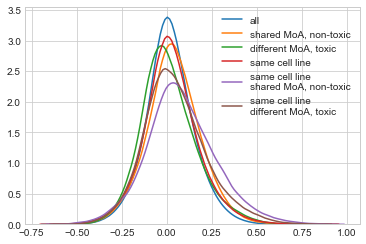

In [45]:
for group in ['all','shared MoA, non-toxic','different MoA, toxic',
             'same cell line','same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic']:
    sns.distplot(results[group],label=group,hist=False)

We can also "simulate" MoA identification process, i.e. how well can we identify compounds with shared MoA based on signature similarity. For this we will use consensus signatures for each compunds in our CTRP dataset.

In [610]:
# just for consensus signature calculation
LM_GENES=gene_correlations.index
def calc_MODZ(data):
    """calculates MODZ based on the original CMAP/L1000 study
    use only lm genes for MODZ calculation! Uses LM_GENES global
    variable."""
    if len(data)==1:
        return data
    if len(data)==2:
        return np.mean(data,0)*np.sqrt(2)
    else:
        CM=scor(data[LM_GENES].T)[0]
        fil=CM<0
        CM[fil]=0.01
        weights=np.sum(CM,1)-1
        weights=weights/np.sum(weights)
        weights=weights.reshape((-1,1))
        return pd.Series(np.dot(data.T,weights).reshape((-1,1)[0]),index=data.columns)*np.sqrt(len(data))

In [611]:
consensus_signatures=pd.DataFrame(index=list(set(sig_info['pert_id'])),columns=signatures.columns)
for cpd in list(set(sig_info['pert_id'])):
    indexes=list(sig_info.index[sig_info['pert_id']==cpd])
    consensus_signatures.loc[cpd]=calc_MODZ(signatures.loc[indexes]).values

In [612]:
similarity=pd.DataFrame(scor(consensus_signatures.T)[0],index=consensus_signatures.index,
                        columns=consensus_signatures.index)


In [613]:
shared_moa=shared_moa.loc[similarity.index,similarity.columns]

In [614]:
y_pr=similarity.values[np.triu_indices(len(similarity),1)]
y_tr=shared_moa.values[np.triu_indices(len(similarity),1)]

In [615]:
fpr,tpr,dummy=ROC(y_tr,y_pr)
pre,rec,dummy=PRC(y_tr,y_pr)
print (AUC(fpr,tpr),AUC(rec,pre),sum(y_tr)/len(y_tr))

0.635071428675 0.0657134601888 0.0128327798728


In [616]:
consensus_signatures=pd.DataFrame(index=list(set(sig_info['pert_id'])),columns=signatures.columns)
for cpd in list(set(sig_info['pert_id'])):
    indexes=list(sig_info.index[sig_info['pert_id']==cpd])
    consensus_signatures.loc[cpd]=calc_MODZ(signatures_residuals.loc[indexes]).values
similarity=pd.DataFrame(scor(consensus_signatures.T)[0],index=consensus_signatures.index,
                        columns=consensus_signatures.index)

shared_moa=shared_moa.loc[similarity.index,similarity.columns]
y_pr=similarity.values[np.triu_indices(len(similarity),1)]
y_tr=shared_moa.values[np.triu_indices(len(similarity),1)]

In [617]:
fpr,tpr,dummy=ROC(y_tr,y_pr)
pre,rec,dummy=PRC(y_tr,y_pr)
print (AUC(fpr,tpr),AUC(rec,pre),sum(y_tr)/len(y_tr))

0.616549089653 0.048989898597 0.0128327798728


In [618]:
genes=gene_correlations.index[700:]
LM_GENES=genes
consensus_signatures=pd.DataFrame(index=list(set(sig_info['pert_id'])),columns=genes)
for cpd in list(set(sig_info['pert_id'])):
    indexes=list(sig_info.index[sig_info['pert_id']==cpd])
    consensus_signatures.loc[cpd]=calc_MODZ(signatures.loc[indexes,genes]).values
similarity=pd.DataFrame(scor(consensus_signatures.T)[0],index=consensus_signatures.index,
                        columns=consensus_signatures.index)

shared_moa=shared_moa.loc[similarity.index,similarity.columns]
y_pr=similarity.values[np.triu_indices(len(similarity),1)]
y_tr=shared_moa.values[np.triu_indices(len(similarity),1)]

In [619]:
fpr,tpr,dummy=ROC(y_tr,y_pr)
pre,rec,dummy=PRC(y_tr,y_pr)
print (AUC(fpr,tpr),AUC(rec,pre))

0.712755544397 0.0946382007184


In [87]:
# just for consensus signature and 
def calc_MODZ_and_death(data,death):
    """calculates MODZ based on the original CMAP/L1000 study
    use only lm genes for MODZ calculation! Uses LM_GENES global
    variable."""
    if len(data)==1:
        return data,death
    if len(data)==2:
        return np.mean(data,0),np.mean(death,0)
    else:
        CM=scor(data.T)[0]
        fil=CM<0
        CM[fil]=0.01
        weights=np.sum(CM,1)-1
        weights=weights/np.sum(weights)
        weights=weights.reshape((-1,1))
        return (pd.Series(np.dot(data.T,weights).reshape((-1,1)[0]),index=data.columns),
               pd.Series(np.dot(death.T,weights).reshape((-1,1)[0])))
                

In [88]:
consensus_signatures=pd.DataFrame(index=list(set(sig_info['pert_id'])),columns=signatures.columns)
consensus_death=pd.DataFrame(index=consensus_signatures.index,columns=['cpd_avg_pv'])
for cpd in list(set(sig_info['pert_id'])):
    indexes=list(sig_info.index[sig_info['pert_id']==cpd])
    temp=calc_MODZ_and_death(signatures_residuals.loc[indexes],pd.DataFrame(sig_info.loc[indexes,'cpd_avg_pv']))
    consensus_signatures.loc[cpd]=temp[0].values
    consensus_death.loc[cpd,'cpd_avg_pv']=temp[1].values[0]
consensus_death=consensus_death.astype(float)

In [89]:
model=LinearRegression()
for gene in consensus_signatures.columns:
    model.fit(sig_info['cpd_avg_pv'].values.reshape(-1, 1),signatures[gene])
    y_pr=model.predict(consensus_death['cpd_avg_pv'].values.reshape(-1, 1))
    consensus_signatures[gene]=consensus_signatures[gene]-y_pr

In [90]:
similarity=pd.DataFrame(scor(consensus_signatures.T)[0],index=consensus_signatures.index,
                        columns=consensus_signatures.index)
shared_moa=shared_moa.loc[similarity.index,similarity.columns]
y_pr=similarity.values[np.triu_indices(len(similarity),1)]
y_tr=shared_moa.values[np.triu_indices(len(similarity),1)]

In [91]:
fpr,tpr,dummy=ROC(y_tr,y_pr)
pre,rec,dummy=PRC(y_tr,y_pr)
print (AUC(fpr,tpr),AUC(rec,pre),sum(y_tr)/len(y_tr))

0.664435187436 0.0386881075738 0.0128327798728


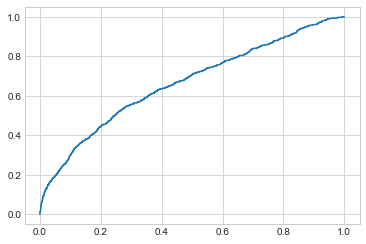

In [93]:
plt.plot(fpr,tpr)

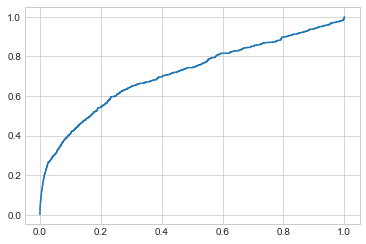

In [98]:
plt.plot(fpr,tpr)

In [99]:
similarity

,BRD-K58772419,BRD-A59431241,BRD-K43389698,BRD-K89162000,BRD-K51490254,BRD-K74514084,BRD-K84466663,BRD-K85606544,BRD-K93754473,BRD-K08589866,...,BRD-K35716340,BRD-K63431240,BRD-K44241590,BRD-K73261812,BRD-K49075727,BRD-K75295174,BRD-K55696337,BRD-K71726959,BRD-K37865504,BRD-K05649647
BRD-K58772419,1.000000,0.326564,0.079509,0.368602,0.023895,0.391787,0.152242,0.341962,0.545149,0.355947,...,-0.067180,0.108149,0.348242,0.104619,0.209413,0.313976,0.034255,0.298372,0.133346,0.202408
BRD-A59431241,0.326564,1.000000,0.216880,0.360741,-0.085894,0.366028,0.053289,0.485791,0.518200,0.141029,...,0.093116,0.122196,0.233090,0.280365,0.256534,0.340259,0.059833,0.142874,0.147615,0.220326
BRD-K43389698,0.079509,0.216880,1.000000,0.278775,0.071642,0.317490,0.437225,0.131969,0.176855,0.100056,...,0.038195,-0.001596,0.325069,-0.055587,0.378959,-0.060314,0.329603,0.392234,0.030789,0.265020
BRD-K89162000,0.368602,0.360741,0.278775,1.000000,0.092577,0.548674,0.445712,0.376712,0.599476,0.208562,...,0.154465,0.130868,0.452451,-0.002338,0.444252,0.210202,0.144932,0.269259,0.132542,0.290638
BRD-K51490254,0.023895,-0.085894,0.071642,0.092577,1.000000,0.203520,0.155713,0.042969,0.001711,0.033748,...,0.023142,-0.096426,0.054085,0.120391,-0.054707,-0.035854,0.031216,0.026934,0.036342,0.092142
BRD-K74514084,0.391787,0.366028,0.317490,0.548674,0.203520,1.000000,0.452283,0.385134,0.443591,0.237823,...,-0.009221,0.040785,0.340847,0.146912,0.345699,0.190884,0.045069,0.319201,0.029159,0.375693
BRD-K84466663,0.152242,0.053289,0.437225,0.445712,0.155713,0.452283,1.000000,0.158939,0.164898,0.130172,...,-0.019428,-0.029862,0.302151,-0.032237,0.400356,-0.083937,0.115399,0.183173,-0.090057,0.241738
BRD-K85606544,0.341962,0.485791,0.131969,0.376712,0.042969,0.385134,0.158939,1.000000,0.456940,0.196377,...,0.006833,0.124480,0.229860,0.303032,0.332468,0.171522,-0.017039,0.107385,0.074145,0.279303
BRD-K93754473,0.545149,0.518200,0.176855,0.599476,0.001711,0.443591,0.164898,0.456940,1.000000,0.278024,...,0.044153,0.200167,0.387895,0.100978,0.453232,0.407306,0.043351,0.233531,0.116050,0.269219
BRD-K08589866,0.355947,0.141029,0.100056,0.208562,0.033748,0.237823,0.130172,0.196377,0.278024,1.000000,...,-0.070187,0.045188,0.147688,0.214497,0.275173,0.247491,0.057978,0.315568,-0.039038,-0.037118


In [138]:
chemichal=pd.read_table('../data/Chemical/LINCS_PertID_SMILES_MorganFP_1024bits.csv',
                       sep=',',header=0,index_col=[0])
chemichal.index=chemichal['CompoundNames']
chemichal=chemichal.iloc[:,:-1].astype(bool)

In [139]:
cpds=list(set(similarity.index)&set(chemichal.index))
similarity=similarity.loc[cpds,cpds]
chemichal=chemichal.loc[cpds]

In [145]:
for i in similarity.index:
    similarity.loc[i]=np.sum(chemichal.loc[i]&chemichal,1)/np.sum(chemichal.loc[i]|chemichal,1)

In [146]:
shared_moa=shared_moa.loc[similarity.index,similarity.columns]
y_pr=similarity.values[np.triu_indices(len(similarity),1)]
y_tr=shared_moa.values[np.triu_indices(len(similarity),1)]

In [147]:
fpr,tpr,dummy=ROC(y_tr,y_pr)
pre,rec,dummy=PRC(y_tr,y_pr)
print (AUC(fpr,tpr),AUC(rec,pre),sum(y_tr)/len(y_tr))

0.756751676024 0.154204145849 0.0122482150113


In [266]:
sensitivity=pd.read_table('../results/CTRP/ctrp_DR.csv',sep=',',
                         header=0,index_col=[0])
sensitivity=sensitivity.drop_duplicates(['ccl_name','broad_cpd_id'])
sensitivity=sensitivity.pivot(index='ccl_name',columns='broad_cpd_id',values='area_under_curve')
fil=pd.isnull(sensitivity)
sensitivity[fil]=14

In [267]:
similarity=pd.DataFrame(np.corrcoef(sensitivity.T),index=sensitivity.columns,columns=sensitivity.columns)

In [268]:
cpds=list(set(similarity.index)&set(shared_moa.index))

In [269]:
shared_moa=shared_moa.loc[cpds,cpds]
similarity=similarity.loc[cpds,cpds]
y_pr=similarity.values[np.triu_indices(len(similarity),1)]
y_tr=shared_moa.values[np.triu_indices(len(similarity),1)]

In [270]:
fpr,tpr,dummy=ROC(y_tr,y_pr)
pre,rec,dummy=PRC(y_tr,y_pr)
print (AUC(fpr,tpr),AUC(rec,pre),sum(y_tr)/len(y_tr))

0.79095293596 0.117391777925 0.0120547760389


We can check this in repurposing dataset.

In [353]:
drug_rep=pd.read_table('../data/Repurposing/repurposing_drugs_20180907.txt',
                      sep='\t',header=9,encoding='latin-1',index_col=[0])
samp_rep=pd.read_table('../data/Repurposing/repurposing_samples_20180907.txt',
                      sep='\t',header=9,encoding='latin-1')
fil=~pd.isnull(drug_rep['target'])
drug_rep_tr=drug_rep[fil]
fil=~pd.isnull(drug_rep['moa'])
drug_rep_moa=drug_rep[fil]
samp_rep['broad_id']=samp_rep['broad_id'].apply(lambda x: '-'.join(x.split('-')[:2]))

In [354]:
targets=[]
for i in drug_rep_tr.index:
    targets+=drug_rep_tr.loc[i,'target'].split('|')
targets=list(set(targets))
moas=[]
for i in drug_rep_moa.index:
    moas+=drug_rep_moa.loc[i,'moa'].split('|')
moas=list(set(moas))

In [355]:
target_matrix=pd.DataFrame(0,index=drug_rep_tr.index,columns=targets)
moa_matrix=pd.DataFrame(0,index=drug_rep_moa.index,columns=moas)

In [356]:
for cpd in target_matrix.index:
    target_matrix.loc[cpd,drug_rep_tr.loc[cpd,'target'].split('|')]=1
for cpd in moa_matrix.index:
    moa_matrix.loc[cpd,drug_rep_moa.loc[cpd,'moa'].split('|')]=1

In [379]:
all_cpds=list(set(target_matrix.index) & set(moa_matrix.index))
all_cpd_dict={}
for cpd in all_cpds:
    all_cpd_dict[cpd]=list(set(samp_rep[samp_rep['pert_iname']==cpd]['broad_id']))

In [390]:
sig_info_gse70138=pd.read_table('../data/LINCS/GSE70138/GSE70138_Broad_LINCS_sig_info.txt',
                               sep='\t',header=0,index_col=[0],low_memory=False)
sig_info_gse92742=pd.read_table('../data/LINCS/GSE92742/GSE92742_Broad_LINCS_sig_info.txt',
                               sep='\t',header=0,index_col=[0],low_memory=False)
gene_info=pd.read_table('../data/LINCS/GSE92742/GSE92742_Broad_LINCS_gene_info.txt',sep='\t')
fil=gene_info['pr_is_lm']==1 # change the columns name to pr_is_bing if you are interested for all genes
gene_ids = list(gene_info.loc[gene_info.index[fil],'pr_gene_id'].astype(str))

In [408]:

for cpd in all_cpd_dict:
    fil=(sig_info_gse70138['pert_iname']==cpd) | np.in1d(sig_info_gse70138['pert_id'],all_cpd_dict[cpd])
    sig_ids_gse70138=sig_info_gse70138.index[fil]
    if len(sig_ids_gse70138)>0:
        signatures_gse70138=parse('../data/LINCS/GSE70138/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328.gctx', 
                                  cid=sig_ids_gse70138,rid=gene_ids).data_df.T[gene_ids]
    else:
        signatures_gse70138=None
    fil=(sig_info_gse92742['pert_iname']==cpd) | np.in1d(sig_info_gse92742['pert_id'],all_cpd_dict[cpd])
    sig_ids_gse92742=sig_info_gse92742.index[fil]
    if len(sig_ids_gse92742)>0:
        signatures_gse92742=parse('../data/LINCS/GSE92742/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', 
                                  cid=sig_ids_gse92742,rid=gene_ids).data_df.T[gene_ids]
    else:
        signatures_gse92742=None
    if (len(sig_ids_gse70138)>0) | (len(sig_ids_gse92742)>0):
        signatures=pd.concat([signatures_gse92742,signatures_gse70138])
        fname=cpd
        if '/' in cpd:
            fname=''
            for c in cpd:
                if c!='/':
                    fname+=c
        signatures.to_csv('../results/moa/signatures/%s.csv' % fname,sep=',')

In [440]:
# just for consensus signature calculation
def calc_MODZ(data):
    """calculates MODZ based on the original CMAP/L1000 study
    use only lm genes for MODZ calculation! Uses LM_GENES global
    variable."""
    if len(data)==1:
        return data
    if len(data)==2:
        return np.mean(data,0)
    else:
        CM=scor(data.T)[0]
        fil=CM<0
        CM[fil]=0.01
        weights=np.sum(CM,1)-1
        weights=weights/np.sum(weights)
        weights=weights.reshape((-1,1))
        return pd.Series(np.dot(data.T,weights).reshape((-1,1)[0]),index=data.columns)

In [441]:
compounds=pd.Series(os.listdir('../results/moa/signatures/')).apply(lambda x:x[:-4]).values
consensus=pd.DataFrame(index=compounds,columns=gene_correlations.index)
consensus_700=pd.DataFrame(index=compounds,columns=gene_correlations.index[700:])

In [442]:
for cpd in compounds:
    if list(compounds).index(cpd) % 50 ==0:
        print(cpd,flush=True)
    signature=pd.read_table('../results/moa/signatures/%s.csv' % cpd,sep=',',
                           header=0,index_col=[0])[gene_correlations.index]
    consensus.loc[cpd]=calc_MODZ(signature)
    consensus_700.loc[cpd]=calc_MODZ(signature[consensus_700.columns])

arecaidine-propargyl-ester
losmapimod
ixabepilone
sobetirome
vemurafenib
ML-281
GW-842166
hydroflumethiazide
thiostrepton
mCPP
midodrine
pralidoxime
anisodamine
ML-141
GSK1904529A
ephedrine-(racemic)
epinastine
piribedil
KU-60019
WH-4-023
bergenin
voxtalisib
10-hydroxycamptothecin
moexipril
amifostine
benzethonium
diazoxide
promethazine
XE-991
pomalidomide
timofibrate
geldanamycin
delanzomib
terfenadine
mexiletine
flunarizine
dienestrol
ABC-294640
CGP-20712A
MK-1775
isamoltane
tretinoin
urea
dienogest
metamizole
pantoprazole
DCPIB
oxotremorine-sesquifumarate
norgestrel
4-iodo-6-phenylpyrimidine
ZM-306416


In [444]:
consensus.to_csv('../results/moa/rep_cons.csv',sep=',')
consensus_700.to_csv('../results/moa/rep_cons_700.csv',sep=',')

In [445]:
similarity=pd.DataFrame(scor(consensus.T)[0],index=consensus.index,columns=consensus.index)
similarity_700=pd.DataFrame(scor(consensus_700.T)[0],index=consensus_700.index,columns=consensus_700.index)

In [450]:
shared_moa=pd.DataFrame(np.identity(len(moa_matrix),int),index=moa_matrix.index,columns=moa_matrix.index)
for cpd in moa_matrix.index:
    acts=moa_matrix.columns[moa_matrix.loc[cpd]==1]
    sim_act=moa_matrix.index[np.sum(moa_matrix[acts],1)>0]
    shared_moa.loc[cpd,sim_act]=1
    

In [451]:
shared_target=pd.DataFrame(np.identity(len(target_matrix),int),index=target_matrix.index,columns=target_matrix.index)
for cpd in target_matrix.index:
    acts=target_matrix.columns[target_matrix.loc[cpd]==1]
    sim_act=target_matrix.index[np.sum(target_matrix[acts],1)>0]
    shared_target.loc[cpd,sim_act]=1

In [467]:
cpds=list(set(shared_target.index)&set(similarity_700.index))

y_pr=similarity_700.loc[cpds,cpds].values[np.triu_indices(len(cpds),1)]
y_tr=shared_target.loc[cpds,cpds].values[np.triu_indices(len(cpds),1)]

fpr,tpr,dummy=ROC(y_tr,y_pr)
pre,rec,dummy=PRC(y_tr,y_pr)
print (AUC(fpr,tpr),AUC(rec,pre),sum(y_tr)/len(y_tr))

0.617388305792 0.0347288972313 0.0176889955982


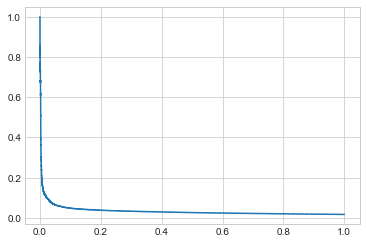

In [464]:
plt.plot(rec,pre)

In [468]:
y_pr

array([ 0.04512454,  0.18592128,  0.14008265, ...,  0.40186647,
        0.26078767,  0.17833019])

In [469]:
y_tr

array([0, 0, 0, ..., 0, 0, 0])

{'boxes': [<matplotlib.lines.Line2D at 0x1d2cbecf8>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1ac72b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a1a91c18>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a1a91ac8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1ca5998d0>,
  <matplotlib.lines.Line2D at 0x19e0dcb70>]}

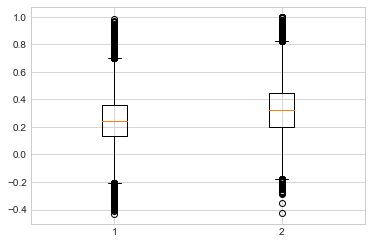

In [475]:
plt.boxplot([list(y_pr[~y_tr.astype(bool)]),list(y_pr[y_tr.astype(bool)])])

In [497]:
similarity_700['tamoxifen'].sort_values()

hexamethonium         -0.077550
ACDPP                 -0.059857
IPI-145               -0.053590
cabazitaxel           -0.048056
KX2-391               -0.046368
genz-644282           -0.041598
ixabepilone           -0.030752
SB-743921             -0.029571
epothilone-b          -0.025352
YC-1                  -0.025086
methoxamine           -0.022008
dyclonine             -0.017501
acetohexamide         -0.014083
chicago-sky-blue-6b   -0.012136
levodopa              -0.011559
NMS-1286937           -0.011243
GSK923295             -0.003766
dolastatin-10          0.006816
pralidoxime            0.013261
aceclofenac            0.014995
docetaxel              0.020942
SN-38                  0.021586
dalfampridine          0.021870
trimethadione          0.024841
trichlormethiazide     0.025551
xylometazoline         0.027389
pevonedistat           0.029158
butenafine             0.029419
trihexyphenidyl        0.031086
podophyllotoxin        0.031418
                         ...   
tivozani

In [481]:
shared_target

pert_iname,"[sar9,met(o2)11]-substance-p",A-1070722,A-1120,A-317491,A-366,A-412997,A-438079,A-582941,A-61603,A-674563,...,7-hydroxy-PIPAT,7-hydroxystaurosporine,7-methoxytacrine,7-nitroindazole,8-bromo-cGMP,8-hydroxy-DPAT,8-hydroxy-PIPAT,8-M-PDOT,9-aminocamptothecin,9-anthracenecarboxylic-acid
pert_iname,,,,,,,,,,,,,,,,,,,,,
"[sar9,met(o2)11]-substance-p",1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A-1070722,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
A-1120,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A-317491,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A-366,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A-412997,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A-438079,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A-582941,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
A-61603,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
